# Obtaining lightcurves of clusters

In this tutorial, we will obtain lightcurves of certain star clusters and display their images using `eleanor`.

This is a companion to the view-clusters notebook, which takes a different approach. This approach has the advantage of using the in-built tools of `eleanor` but it can't handle images larger than 31x31 pixels, let alone the 180x180 pixel (1 deg x 1 deg) images asked for.

In [1]:
from IPython.display import Image

import eleanor
import numpy as np
from astropy import units as u
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord

import warnings
warnings.filterwarnings('ignore')

Error initializing plugin EntryPoint(name='Windows (alt)', value='keyrings.alt.Windows', group='keyring.backends').
Traceback (most recent call last):
  File "/home/jtdinsmo/.local/lib/python3.6/site-packages/keyring/backend.py", line 203, in _load_plugins
    init_func = ep.load()
  File "/home/jtdinsmo/.local/lib/python3.6/site-packages/importlib_metadata/__init__.py", line 96, in load
    module = import_module(match.group('module'))
  File "/usr/lib/python3.6/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 994, in _gcd_import
  File "<frozen importlib._bootstrap>", line 971, in _find_and_load
  File "<frozen importlib._bootstrap>", line 955, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 665, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 678, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_f

In [2]:
WIDTH = 30# Maximized at 31
CLUSTER_NAME = "M34"

In [3]:
star = eleanor.Source(name=CLUSTER_NAME)

print('Found TIC {0} (Gaia {1}), with TESS magnitude {2}, RA {3}, and Dec {4}'
     .format(star.tic, star.gaia, star.tess_mag, star.coords[0], star.coords[1]))

No eleanor postcard has been made for your target (yet). Using TessCut instead.
Found TIC 302083419 (Gaia 337154005024517120), with TESS magnitude 18.0423, RA 40.520833333333336, and Dec 42.76166666666667


In [4]:
data = eleanor.TargetData(star, height=WIDTH, width=WIDTH, bkg_size=31, do_psf=True, do_pca=True)

100%|██████████| 1107/1107 [00:17<00:00, 62.44it/s]


<Figure size 1080x360 with 0 Axes>

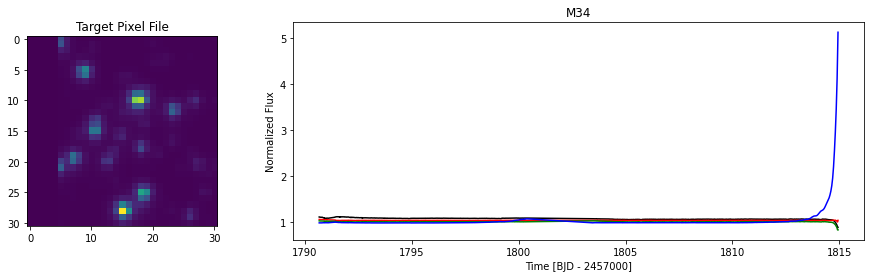

In [5]:
plt.figure(figsize=(15,5))

q = data.quality == 0

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,4), gridspec_kw={'width_ratios':[1,3]})
ax1.imshow(data.tpf[0])
ax1.set_title('Target Pixel File')

ax2.plot(data.time[q], data.raw_flux[q]/np.nanmedian(data.raw_flux[q])+0.06, 'k')
ax2.plot(data.time[q], data.corr_flux[q]/np.nanmedian(data.corr_flux[q]) + 0.03, 'r')
ax2.plot(data.time[q], data.pca_flux[q]/np.nanmedian(data.pca_flux[q]), 'g')
ax2.plot(data.time[q], data.psf_flux[q]/np.nanmedian(data.psf_flux[q]) - 0.02, 'b')
ax2.set_ylabel('Normalized Flux');
ax2.set_xlabel('Time [BJD - 2457000]');
ax2.set_title(CLUSTER_NAME);

I wasn't really able to do what I wanted to do because I can't make a big image.